# ⚒️ Mining Dickens ⚒️ Part II: Topic modelling, sentiment analysis and character network analysis

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt

import spacy
# !python -m spacy download en_core_web_sm # prepending "!" makes this run as a command line input
import en_core_web_sm
nlp = en_core_web_sm.load()
nlp.max_length = 2000000 # default limit for spacy is 1M, but we need more than that. You can check the length of your text with len(text)

google_stopwords = []
with open('../inputs/google-stopwords.txt') as intxt:
    for word in intxt.readlines():
        google_stopwords.append(word.strip())


## Import the texts

Let's first import the text of some novels. We'll use _Great Expectations_, _Oliver Twist_ and _David Copperfield_. Several out-of-copyright texts such as these can be freely downloaded from [Project Gutenberg](https://www.gutenberg.org), where you'll find also many non-English works if you'd like to experiment with your own texts.

In [2]:
with open('../inputs/data/greatexpectations.txt', 'r') as intxt:
    greatexpectations = intxt.read()

with open('../inputs/data/olivertwist.txt', 'r') as intxt:
    olivertwist = intxt.read()

with open('../inputs/data/davidcopperfield.txt', 'r') as intxt:
    davidcopperfield = intxt.read()

## Basic preprocessing

Now we start with the _preprocessing_ stage of text analysis - which is well-known to be time-consuming (and often more so than the analysis itself!). The next step needs to be bespoke for each of the files. For each text, we remove unwanted text that isn't part of the novel. To determine this you'll need to have a look at the individual files and establish which string can unequivocably be considered as the cut-off point for the beginning and end of the novel:

In [3]:
greatexpectations = greatexpectations.split(' Chapter LIX. AND LAST')[-1].strip()
greatexpectations = greatexpectations.split('*** END OF THE PROJECT GUTENBERG EBOOK GREAT EXPECTATIONS ***')[0].strip()

olivertwist = olivertwist.split('LIII     AND LAST')[-1].strip()
olivertwist = olivertwist.split('*** END OF THE PROJECT GUTENBERG EBOOK OLIVER TWIST ***')[0].strip()

davidcopperfield = davidcopperfield.split('THE PERSONAL HISTORY AND EXPERIENCE OF DAVID COPPERFIELD THE YOUNGER')[-1].strip()
davidcopperfield = davidcopperfield.split('*** END OF THE PROJECT GUTENBERG EBOOK DAVID COPPERFIELD ***')[0].strip()

## Sentiment analysis

[Sentiment analysis]() helps automatically identify and quantify the emotional tone in a text or the subjective attitude towards the particular topic being narrated or discussed or with respect to a given statement. It's a complex topic, with many downstream applications (particularly in marketing and social media opinion mining) - we will only get a taste of what it looks like and what it can do on literary text.

We'll use the _Valence Aware Dictionary and sEntiment Reasoner_ ([VADER](https://pypi.org/project/vaderSentiment/)) tool, which is actually specifically fine-tuned to social media sentiments, but has been used on a variety of texts from other domains.

In [4]:
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# pd.options.display.max_colwidth = 400
import warnings # suppress warnings because they are not relevant for us here
warnings.simplefilter(action='ignore', category=FutureWarning)
# !pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/npedrazzini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

We first initialize the sentiment analyser:

In [5]:
sentimentAnalyser = SentimentIntensityAnalyzer()

Let's try out on one intuitively positive and one negative sentence:

In [6]:
print(sentimentAnalyser.polarity_scores("This lecture is super useful!"))
print(sentimentAnalyser.polarity_scores("This lecture is so bad!"))

{'neg': 0.0, 'neu': 0.297, 'pos': 0.703, 'compound': 0.7959}
{'neg': 0.545, 'neu': 0.455, 'pos': 0.0, 'compound': -0.6988}


The analyser spits out 4 metrics:
- `neg`: measure of negative attitude/opinion/sentiment
- `neu`: measure of neutral attitude/opinion/sentiment
- `pos`: measure of positive attitude/opinion/sentiment
- `compound`: compound overall measure of sentiment

What we're generally interested in is the _compound measure_. It ranges between `-1` and `1`. The closer to `0` the more neutral the score will be. The closer to `-1` the more negative and the closer to `1` the more positive it will be.

We can now try it on one of the novels. We will use individual sentences and chapters as units to try and capture the overall sentiment curve in the novels, but in other scenarios you could use time stamps/chunks of different types depending on your research goals! Let's try it on Oliver Twist again.

Let's first identify the chapters:

In [7]:
pattern = r'CHAPTER [IVXL]+' # any Roman numeral repeated any amount of times

And split the text into them:

In [8]:
olivertwist_chapters = re.split(pattern, olivertwist)[1:]

Let's create a dataframe with one sentence per line and for each sentence 3 variables:
- Chapter number it is taken from
- The text of the sentence itself
- The sentiment score (compound)

We'll iterate over each chapter, split it into sentences, assign a sentiment score to each sentecne in order and append a new row corresponding to the sentences to a big list in a for-loop.

After that, we'll turn the big list into a dataframe which we can analyse (structured data, yay!).

In [9]:
listofrows = []

for index, chapter in enumerate(olivertwist_chapters): 
    sentences = nltk.sent_tokenize(chapter)
    print(index)
    for sentence in sentences:
        sentiment_score = sentimentAnalyser.polarity_scores(sentence)
        sentence_row = [index+1, sentence.strip(),sentiment_score['compound']]
        listofrows.append(sentence_row)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


Let's create a dataframe with three columns: 1. Chapter number 2. Text of the chapter 3. Compound sentiment score.

In [10]:
df_sentiment = pd.DataFrame(listofrows, columns=['chapter', 'text','sentiment_score'])

Let's have look at the results. Check the 10 most negative sentences:

In [11]:
df_sentiment.sort_values(by='sentiment_score')[:10]

,chapter,text,sentiment_score
3547,30,if when we oppress and grind our\nfellow-creat...,-0.9894
5624,47,Mortification at the overthrow of his notable ...,-0.9840
5986,49,"Those proofs were destroyed by you, and now, i...",-0.9763
2396,20,"Here, he read of\ndreadful crimes that made th...",-0.9716
3047,26,"Cunning, ferocity, and drunkeness in all its s...",-0.9667
1785,15,Mind him!”\n\nWeak with recent illness; stupif...,-0.9656
4746,40,The miserable companion of thieves and ruffian...,-0.9646
615,6,But his spirit was roused\nat last; the cruel ...,-0.9620
45,2,Unfortunately for the experimental philosophy ...,-0.9618
196,3,"He only cried bitterly all\nday; and, when the...",-0.9612


And the 10 most positive ones:

In [12]:
df_sentiment.sort_values(by='sentiment_score')[-10:]

,chapter,text,sentiment_score
6549,53,I would paint\nher the life and joy of the fir...,0.9845
4074,34,"Above stairs, the remainder of the evening pas...",0.9851
1120,11,"There\nwere the faces of friends, and foes, an...",0.9853
1563,14,The persons on whom I have bestowed my\ndeares...,0.9854
3202,27,ATONES FOR THE UNPOLITENESS OF A FORMER CHAPTE...,0.9855
4192,35,"As we have met\nto-day, we meet no more; but i...",0.9864
3455,29,The very\nintelligence that shone in her deep ...,0.9873
4633,39,"It’s near ten, and nothing done yet.”\n\nIn ob...",0.9885
3730,32,"But, at length, he began, by slow degrees, to ...",0.9925
1351,12,"A\nweakness on his part, which affords the nar...",0.9956


We can now visualize the sentiment curve in _Oliver Twist_. 

Instead of visualizing the score for every single sentence in the novel we will use the average over a rolling window. Pandas `rolling` makes calculations for each observation in a specified column based on a rolling window. For example, if we wanted to look at the overall sentiment curve in a novel, we might want to visualise it _not_ using the sentiment score for each sentence, since this varies wildly from one to the next, but by normalizing the sentiment score for a particular sentence to the average sentiment score of surrounding sentences. The number of surrounding sentences before and after is the _rolling window_. The higher the window, in our case, the more we will capture sentiment over a longer stretch of the novel. Say we decide to compare a rolling window of 100, 500, 1000 and plot the sentiment score in _Oliver Twist_ based on this. 

Let's first add a column for each of these windows:

In [13]:
df_sentiment['sc_100'] = df_sentiment.rolling(100)['sentiment_score'].mean()
df_sentiment['sc_500'] = df_sentiment.rolling(500)['sentiment_score'].mean()
df_sentiment['sc_1000'] = df_sentiment.rolling(1000)['sentiment_score'].mean()

Now let's plot the rolling scores in the same figure, so we can compare them:

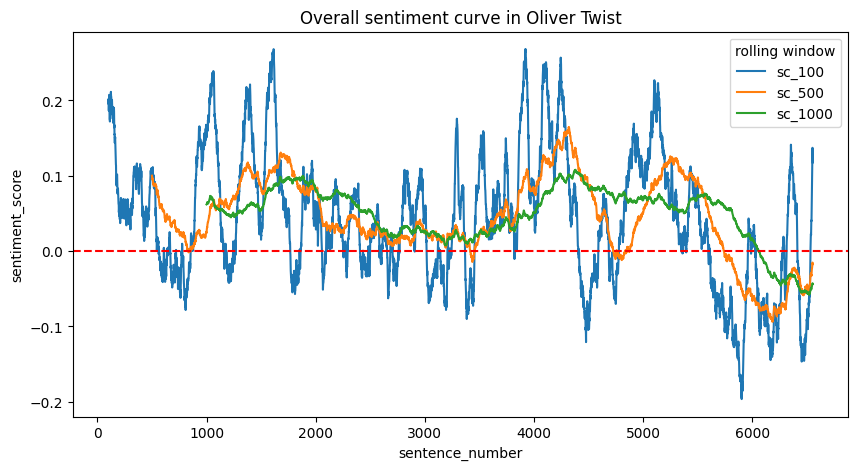

In [14]:
df_sentiment.plot(y=['sc_100','sc_500','sc_1000'],kind='line',figsize=(10,5))
plt.title('Overall sentiment curve in Oliver Twist')
plt.xlabel('sentence_number')
plt.ylabel('sentiment_score')
plt.legend(title='rolling window')
plt.axhline(y=0, color='red', linestyle='--')

plt.show()

Obviously, for each rolling window of _n_ size, the first _n_ sentences will have a value, since we don't have enough observations before them to calculate the mean score. We can adjust this by adding a `min_periods` option, which will run the calculations on the window of _n_ values if available, otherwise it will do so anyway down to the number specified in `min_periods`. We could adjust this value over multiple trials, but perhaps a more systematic way of doing it could be to set `min_periods` to the number corresponding to the lowest number of sentences a chapter in Oliver Twist has: 

In [15]:
df_sentiment['sc_100'] = df_sentiment.rolling(100,min_periods=1)['sentiment_score'].mean()
df_sentiment['sc_500'] = df_sentiment.rolling(500,min_periods=50)['sentiment_score'].mean()
df_sentiment['sc_1000'] = df_sentiment.rolling(1000,min_periods=100)['sentiment_score'].mean()

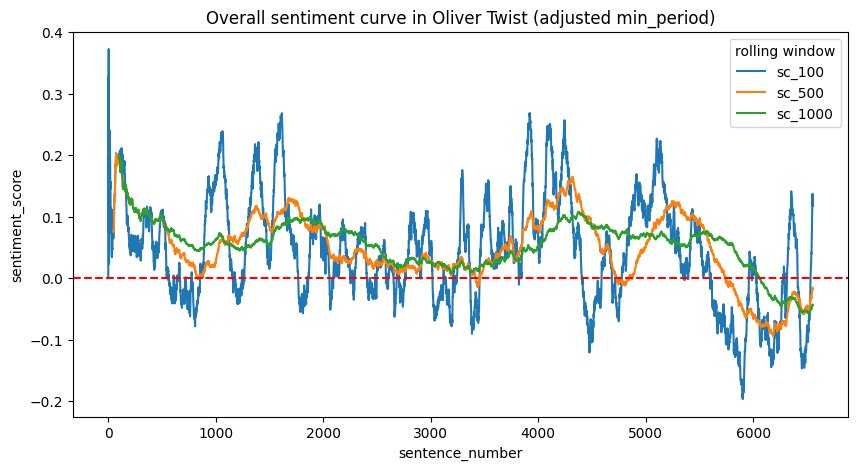

In [16]:
df_sentiment.plot(y=['sc_100','sc_500','sc_1000'],kind='line',figsize=(10,5))
plt.title('Overall sentiment curve in Oliver Twist (adjusted min_period)')
plt.xlabel('sentence_number')
plt.ylabel('sentiment_score')
plt.legend(title='rolling window')
plt.axhline(y=0, color='red', linestyle='--')


We can have a look at the sentiment chapter by chapter as well:

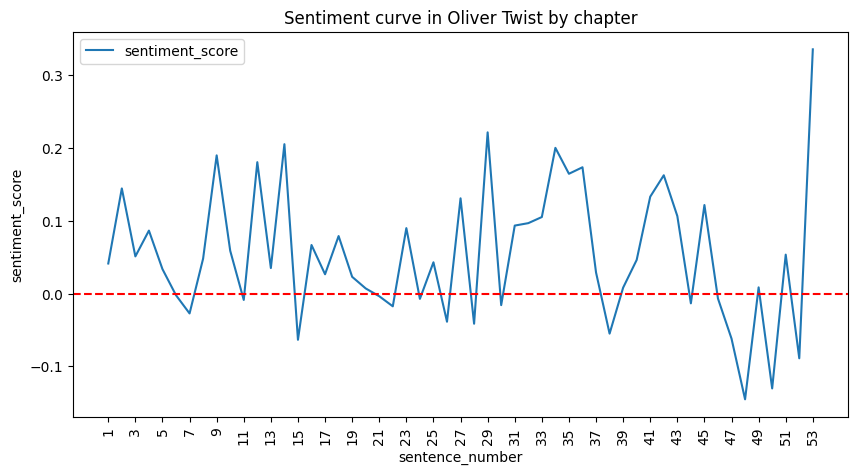

In [17]:
chapters = list(dict.fromkeys(list(df_sentiment['chapter'])))
df_sentiment.groupby('chapter')['sentiment_score'].mean().plot(legend=True,x='chapter', y='sentiment_score',xticks=chapters[::2],rot=90,figsize=(10,5))

plt.title('Sentiment curve in Oliver Twist by chapter')

plt.xlabel('sentence_number')
plt.ylabel('sentiment_score')
plt.axhline(y=0, color='red', linestyle='--')


We can see that there's a (possibly _way too_) sudden change in sentiment in the final chapter. Either the novel has a sudden final spike in overall sentiment score, or perhaps there's something about its text that doesn't make it comparable straightforwardly with the rest. Perhaps number of words? Let's compare the word counts of each chapter:

In [18]:
for chapter in chapters:
    count = 0
    for sentence in df_sentiment[df_sentiment['chapter'] == chapter]['text']:
        count += len(sentence.split())

    print(f'Word count for Ch. {chapter}:', count)

Word count for Ch. 1: 1110
Word count for Ch. 2: 3926
Word count for Ch. 3: 3076
Word count for Ch. 4: 2560
Word count for Ch. 5: 4013
Word count for Ch. 6: 1717
Word count for Ch. 7: 2314
Word count for Ch. 8: 3212
Word count for Ch. 9: 2321
Word count for Ch. 10: 1797
Word count for Ch. 11: 2606
Word count for Ch. 12: 3410
Word count for Ch. 13: 2798
Word count for Ch. 14: 3958
Word count for Ch. 15: 2341
Word count for Ch. 16: 3516
Word count for Ch. 17: 3196
Word count for Ch. 18: 2978
Word count for Ch. 19: 3393
Word count for Ch. 20: 2978
Word count for Ch. 21: 2163
Word count for Ch. 22: 2459
Word count for Ch. 23: 2700
Word count for Ch. 24: 1976
Word count for Ch. 25: 2231
Word count for Ch. 26: 4486
Word count for Ch. 27: 2478
Word count for Ch. 28: 3405
Word count for Ch. 29: 1374
Word count for Ch. 30: 2336
Word count for Ch. 31: 3931
Word count for Ch. 32: 3346
Word count for Ch. 33: 3276
Word count for Ch. 34: 3691
Word count for Ch. 35: 2801
Word count for Ch. 36: 984
Wo

## Topic modelling

Topic modelling is an unsupervised machine learning technique to extract hidden topics from body of texts. It's a complex issue, so, just like with sentiment analysis, we will only get a very superficial taste here, for you to be aware of this method, what tools exist out there to carry out topic modelling, and what inputs and outputs look like. The most popular algorithm for topic modelling is called Latent Dirichlet Allocation (LDA) and we will use the implementation in Python's [Gensim package](https://radimrehurek.com/gensim/intro.html#).

Simply put, LDA represents topics as word-cluster probabilities based on their co-occurrence in a document. Word co-occurrence in a text is a simple but crucial concept for many text mining tasks, so keep that in mind. This means that what LDA returns is lists of words, which you can then interpret as a coherent topic, if possible.

Let's start by importing the necessary libraries as usual. Beside `gensim` we will use `pyLDAvis` to visualize the topics for ease of interpretation.

In [19]:
# !pip install gensim
# !pip install pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

Let's first create a dataframe, with one chapter per row:

In [20]:
olivertwist_chapters = pd.DataFrame({'text': olivertwist_chapters})

As usual, we first have to preprocess our corpus. We will provide lemmata, rather than word forms, and we will remove stopwords as well as some PoS which will unlikely be informative regarding topics. Unlike what we did before, we might not want to include character names as stopwords. At this stage, you may want to use topic modelling to identify which chapters concern a particular character more than others. 

Also, `ldamodel` from Gensim takes two main inputs: 
- a `dictionary`: this is a list of all words in our corpus (i.e. a tokenized corpus) with a unique ID assigned to each of them. This is used to determine the vocabulary size and for topic printing.
- a `bow` (bag-of-word) corpus

Let's first start by tokenizing and lemmatizing the corpus and removing stopwords:

In [21]:
pos_toremove = ['PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
olivertwist_chapters_tok = []

for chapter in nlp.pipe(olivertwist_chapters['text']):
    chapter = [token.lemma_.lower() for token in chapter if token.pos_ not in pos_toremove and token.lemma_.lower() not in google_stopwords and token.is_alpha]
    olivertwist_chapters_tok.append(chapter)

Have a look at the tokenized, lemmatized chapters with stopwords removed:

In [22]:
olivertwist_chapters['tokens'] =  olivertwist_chapters_tok
olivertwist_chapters

,text,tokens
0,.\nTREATS OF THE PLACE WHERE OLIVER TWIST WAS ...,"[treats, place, oliver, twist, bear, circumsta..."
1,".\nTREATS OF OLIVER TWIST’S GROWTH, EDUCATION,...","[treats, oliver, twist, growth, education, boa..."
2,.\nRELATES HOW OLIVER TWIST WAS VERY NEAR GETT...,"[relate, oliver, twist, place, sinecure, week,..."
3,".\nOLIVER, BEING OFFERED ANOTHER PLACE, MAKES ...","[oliver, offer, place, entry, public, life, fa..."
4,.\nOLIVER MINGLES WITH NEW ASSOCIATES. GOING T...,"[oliver, mingles, associates, funeral, forms, ..."
5,".\nOLIVER, BEING GOADED BY THE TAUNTS OF NOAH,...","[oliver, goaded, taunt, noah, rous, action, as..."
6,.\nOLIVER CONTINUES REFRACTORY\n\n\nNoah Clayp...,"[oliver, continues, refractory, noah, claypole..."
7,.\nOLIVER WALKS TO LONDON. HE ENCOUNTERS ON TH...,"[oliver, walks, london, encounter, road, stran..."
8,.\nCONTAINING FURTHER PARTICULARS CONCERNING T...,"[concern, pleasant, gentleman, hopeful, pupils..."
9,.\nOLIVER BECOMES BETTER ACQUAINTED WITH THE C...,"[oliver, acquainted, character, associate, pur..."


We can now use this to generate a `Dictionary()` object:

In [23]:
dictionary = Dictionary(olivertwist_chapters['tokens'])

Which looks like this:

In [24]:
# print(dictionary.token2id)

Let's now generate a BOW for each chapter, as per the second requirement of `LdaModel`:

In [25]:
corpus = [dictionary.doc2bow(doc) for doc in olivertwist_chapters['tokens']]

We can now train the model. We'll stick to `5` topics, but in an actual research scenario you would want to try a few values there as a form of hyperparameter optimization:

In [77]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=200, random_state=56789,minimum_probability=0.6)

These are the topics:

In [78]:
lda_model.print_topics(num_words=30)


[(0,
  '0.016*"oliver" + 0.011*"jew" + 0.011*"sikes" + 0.010*"fagin" + 0.010*"man" + 0.008*"boy" + 0.008*"gentleman" + 0.008*"hand" + 0.007*"girl" + 0.005*"young" + 0.005*"turn" + 0.005*"good" + 0.005*"eye" + 0.005*"night" + 0.005*"head" + 0.005*"door" + 0.004*"room" + 0.004*"face" + 0.004*"dodger" + 0.004*"nancy" + 0.004*"lady" + 0.004*"house" + 0.003*"place" + 0.003*"street" + 0.003*"word" + 0.003*"long" + 0.003*"bates" + 0.003*"sit" + 0.003*"draw" + 0.003*"master"'),
 (1,
  '0.017*"oliver" + 0.014*"bumble" + 0.009*"man" + 0.008*"boy" + 0.008*"sowerberry" + 0.007*"door" + 0.006*"giles" + 0.005*"house" + 0.005*"undertaker" + 0.005*"eye" + 0.005*"sir" + 0.005*"good" + 0.004*"head" + 0.004*"face" + 0.004*"turn" + 0.004*"woman" + 0.004*"hand" + 0.004*"voice" + 0.003*"young" + 0.003*"open" + 0.003*"noah" + 0.003*"long" + 0.003*"window" + 0.003*"stranger" + 0.003*"room" + 0.003*"walk" + 0.003*"tear" + 0.002*"child" + 0.002*"fall" + 0.002*"beadle"'),
 (2,
  '0.017*"bumble" + 0.012*"oliver" 

Let's now display the topics of the novel with `lda_display`:

In [28]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

As expected, keeping the characters, rather than removing them as stopwords, allows us to use them as 'topics'! This way we could use them to roughly identified which chapters deal with a particular group of characters/character interactions.

We get 1 main topic for _Fagin_’s gang (**Topic 3**), 1 for _Bumble_ and _Sowerberry_ (earliest in Oliver’s story) (**Topic 2**), 1 for the _Maylies_ and _Brownlow_ (**Topic 4**).  We see that some characters are split across different topics, since their storylines are crossed at various points in the novel: the Brownlow-Rose-Monks storyline, and the discovery that Monks is Oliver’s half brother, for example, seems to be represented by Topic 1. We also see that _Noah_, for example, is roughly split between 2 topics, one clustering with Fagin’s gang, the other with Sowerberry. This also makes sense: Noah goes from being Sowerberry’s apprentice to a member of Fagin’s gang.

Let's add the identified topics to our by-chapter dataframe, so that we can group chapters depending on their main topic:

In [29]:
topics_column = []

for index, row in olivertwist_chapters.iterrows():
    try:
        topics_column.append(lda_model[corpus][index][0][0] + 1)
    except IndexError:
        topics_column.append('No topic')

olivertwist_chapters['topic_n'] = topics_column

In [30]:
olivertwist_chapters

,text,tokens,topic_n
0,.\nTREATS OF THE PLACE WHERE OLIVER TWIST WAS ...,"[treats, place, oliver, twist, bear, circumsta...",No topic
1,".\nTREATS OF OLIVER TWIST’S GROWTH, EDUCATION,...","[treats, oliver, twist, growth, education, boa...",4
2,.\nRELATES HOW OLIVER TWIST WAS VERY NEAR GETT...,"[relate, oliver, twist, place, sinecure, week,...",4
3,".\nOLIVER, BEING OFFERED ANOTHER PLACE, MAKES ...","[oliver, offer, place, entry, public, life, fa...",4
4,.\nOLIVER MINGLES WITH NEW ASSOCIATES. GOING T...,"[oliver, mingles, associates, funeral, forms, ...",4
5,".\nOLIVER, BEING GOADED BY THE TAUNTS OF NOAH,...","[oliver, goaded, taunt, noah, rous, action, as...",4
6,.\nOLIVER CONTINUES REFRACTORY\n\n\nNoah Clayp...,"[oliver, continues, refractory, noah, claypole...",4
7,.\nOLIVER WALKS TO LONDON. HE ENCOUNTERS ON TH...,"[oliver, walks, london, encounter, road, stran...",4
8,.\nCONTAINING FURTHER PARTICULARS CONCERNING T...,"[concern, pleasant, gentleman, hopeful, pupils...",4
9,.\nOLIVER BECOMES BETTER ACQUAINTED WITH THE C...,"[oliver, acquainted, character, associate, pur...",4


Let's print out which chapters belong to which topic. We'll add 1 to the indices (remember Python starts indexing from 0):

In [31]:
chapters_by_topic = olivertwist_chapters.groupby('topic_n').indices

for topic in chapters_by_topic:
    print(f'Topic {topic}:')
    chapters = []
    for chapter in chapters_by_topic[topic]:
        chapters.append(chapter + 1)
    print(chapters)

Topic 1:
[42, 45]
Topic 2:
[17, 23, 27, 29, 30, 32, 33, 34, 35, 36, 40, 41, 46, 49, 51, 53]
Topic 4:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 20, 22, 25, 26, 37, 39, 43, 44, 47, 52]
Topic 5:
[21, 38, 48, 50]
Topic No topic:
[1, 14, 24, 28, 31]


## Character graphs

Finally, we'll get a taste of graph and network theory applied to the study of the relationships between characters in a novel. One of the best-known recent examples of this is probably [A Network of Thrones](https://networkofthrones.wordpress.com), studying the social networks in the _A song of ice and fire_ saga. 

We'll stick to _Oliver Twist_ and build a very simple network graph based on the co-occurrences of each character name with the others within a defined window of tokens.  

I compiled this dictionary, with the main characters' names as keys and their possible variants as values:

In [32]:
olivertwist_characters_variants = {
    'Oliver Twist': ['Oliver'],
    'Mr. Bumble': ['Mr Bumble','Bumble'],
    'Mrs. Mann': ['Mrs Mann','Mann'],
    'Mr. Sowerberry': ['Mr Sowerberry','Sowerberry'],
    'Noah Claypole': ['Noah', 'Claypole'],
    'Charlotte': ['Charlotte'],
    'Mr. Gamfield': ['Mr Gamfield','Gamfield'],
    'Mr. Brownlow': ['Mr Brownlow','Brownlow'],
    'Mr. Grimwig': ['Mr Grimwig','Grimwig'],
    'Mrs. Bedwin': ['Mrs Bedwin','Bedwin'],
    'Rose Maylie': ['Rose'],
    'Mrs. Maylie': ['Mrs. Maylie','Mrs Maylie','Lindsay', 'Maylie'],
    'Harry Maylie': ['Harry'],
    'Mr. Losberne': ['Mr Losberne','Losberne'],
    'Mr. Giles': ['Mr Giles','Giles'],
    'Mr. Brittles': ['Mr Brittles','Brittles'],
    'Duff': ['Duff'],
    'Blathers':['Blathers'],
    'Fagin': ['Fagin'],
    'Bill Sikes': ['Bill', 'Sikes'],
    "Bull's Eye": ['Bullseye','Bull s eye'],
    'The Artful Dodger': ['Artful Dodger','Artful','Dodger','Jack Dawkins'],
    'Charley Bates': ['Charley', 'Charles Bates', 'Bates'],
    'Toby Crackit': ['Toby','Crackit','Flash'],
    'Nancy': ['Nancy'],
    'Bet': ['Betsy'],
    'Barney': ['Barney'],
    'Agnes Fleming': ['Agnes','Fleming'],
    'Mr. Leeford': ['Mr Leeford','Leeford'],
    'Old Sally': ['Sally Thingummy','Sally'],
    'Mrs. Corney': ['Mrs Corney','Corney'],
    'Monks': ['Edward Leeford','Edward'],
    'Mr. Fang': ['Mr Fang', 'Fang'],
    'Tom Chitling': ['Tom', 'Chitling']
}

We are first going to add a lowercase version of each of the values, since we will be using a lowercased version of the text itself.

In [33]:
for character in olivertwist_characters_variants:
    for variant in olivertwist_characters_variants[character]:
        if variant.lower() not in olivertwist_characters_variants[character]:
            olivertwist_characters_variants[character].append(variant.lower())
        if character not in olivertwist_characters_variants[character]:
            olivertwist_characters_variants[character].append(character)

In [34]:
len(olivertwist_characters_variants)

34

We will start from our string `olivertwist_clean`, which we created above and which looks like this:

In [35]:
olivertwist_clean[0:500]

NameError: name 'olivertwist_clean' is not defined

First off, we will assign a unique ID to each occurrence of a character in the novel. We'll do this by _enumerating_ every token in our novel and by only keeping the tokens (with their ID) that are the value of any of the keys in the dictionary `olivertwist_characters_variants`:

In [ ]:
character_occur_ids = dict()

for i,word in enumerate(olivertwist_clean.lower().split(' ')):
       for k,v in olivertwist_characters_variants.items():
              if word not in v:
                     continue
              character_occur_ids[i] = k

Now we'll use the unique ID to establish the position of each character occurrence in the novel. For every character in our dictionary `olivertwist_characters_variants`, we'll then count how many times each of the other characters occurs within a window of tokens before and after the occurrence itself. Let's set the window to `20` for now:

In [ ]:
interactions = {}
for key in olivertwist_characters_variants: # initialize an empty dictionary with one key for every key in olivertwist_characters_variants
       interactions[key] = []

window = 20

for id in character_occur_ids:
       for i in range(1,window): # We iterate for 20 times
              if id + i in character_occur_ids: # check if there are other characters within id + i tokens after current token
                     interactions[character_occur_ids[id]].append(character_occur_ids[id+i])
              if id - i in character_occur_ids: # check if there are other characters within id + i tokens before current token
                     interactions[character_occur_ids[id]].append(character_occur_ids[id-i])

For every character, we now have a list of all the occurrences of other characters:

In [ ]:
# interactions['Mr. Bumble']

Let's now count the interactions:

In [ ]:
finalinteractions = []

for ch in interactions:
       counter = Counter(interactions[ch])
       for v in counter:
              interaction = [ch,v,counter[v]]
              finalinteractions.append(interaction)

And organize these in a dataframe:

In [ ]:
df_interactions = pd.DataFrame(finalinteractions,columns=['Source','Target','Weight'])
df_interactions.head(20)

,Source,Target,Weight
0,Oliver Twist,Oliver Twist,106
1,Oliver Twist,Mrs. Mann,7
2,Oliver Twist,Mr. Bumble,47
3,Oliver Twist,Bill Sikes,55
4,Oliver Twist,Mr. Gamfield,3
5,Oliver Twist,The Artful Dodger,27
6,Oliver Twist,Mr. Sowerberry,24
7,Oliver Twist,Charlotte,5
8,Oliver Twist,Noah Claypole,27
9,Oliver Twist,Rose Maylie,28


Let's drop rows where source and target are the same:

In [ ]:
df_interactions = df_interactions[df_interactions['Source'] != df_interactions['Target']]
df_interactions.head(20)

,Source,Target,Weight
1,Oliver Twist,Mrs. Mann,7
2,Oliver Twist,Mr. Bumble,47
3,Oliver Twist,Bill Sikes,55
4,Oliver Twist,Mr. Gamfield,3
5,Oliver Twist,The Artful Dodger,27
6,Oliver Twist,Mr. Sowerberry,24
7,Oliver Twist,Charlotte,5
8,Oliver Twist,Noah Claypole,27
9,Oliver Twist,Rose Maylie,28
10,Oliver Twist,Toby Crackit,12


Check how many characters made it to the final dataframe:

In [ ]:
len(list(dict.fromkeys(list(df_interactions['Source']))))

33

Let's now create a network graph based on the interactions. We'll use the popular Python package `networkx` to do so. It has a function called `.from_pandas_edgelist`, so that we can directly use our pandas dataframe `df_interactions` as input, where every row will be considered as a node in the graph:

In [ ]:
import networkx

In [ ]:
olivertwist_network = networkx.from_pandas_edgelist(df_interactions, 'Source', 'Target', 'Weight')

Let's draw a basic network graph:

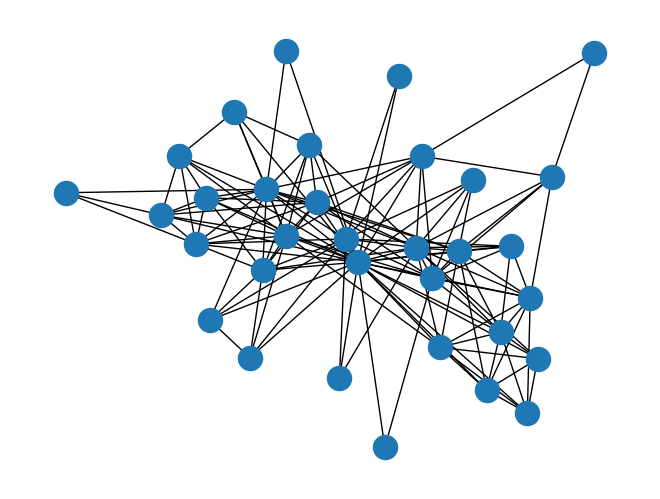

In [ ]:
networkx.draw(olivertwist_network)

Let's now add labels to it:

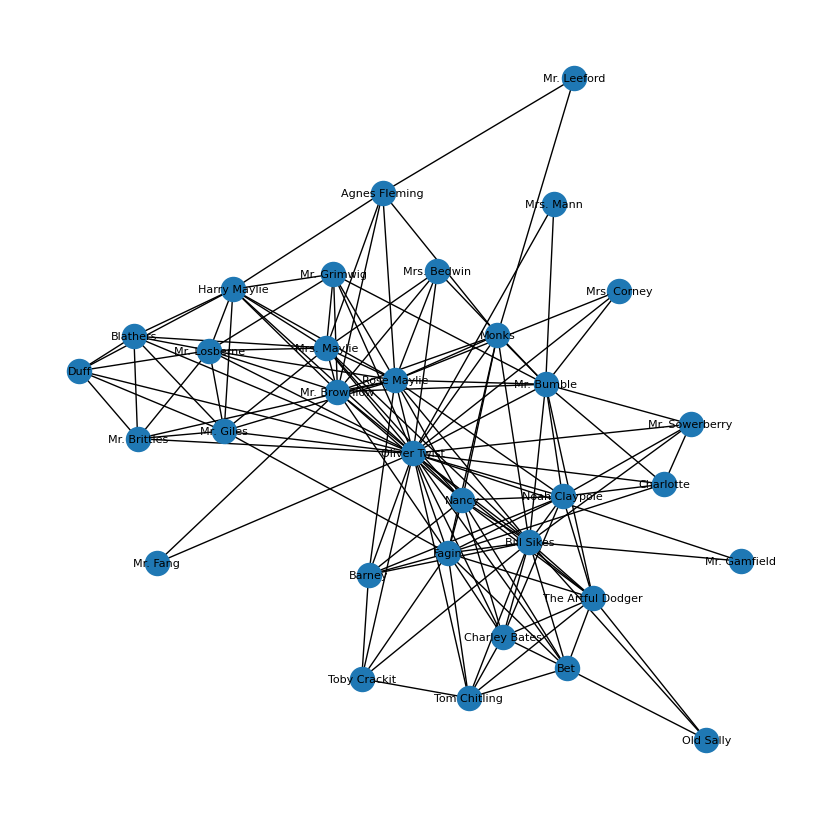

In [ ]:
plt.figure(figsize=(8,8))
networkx.draw(olivertwist_network, with_labels=True, font_size=8)

With even larger novels, or even better series, you can look at potential _communities_ of characters. Once again, see the _Network of Thrones_ example for bang-on example of this! We'll try it out on Oliver Twist using the `community` functions in `networkx`:

In [ ]:
from networkx.algorithms import community

In [ ]:
communities = community.greedy_modularity_communities(olivertwist_network)

Look at the communities identified by the algorith:

In [ ]:
communities

[frozenset({'Agnes Fleming',
            'Blathers',
            'Duff',
            'Harry Maylie',
            'Monks',
            'Mr. Brittles',
            'Mr. Brownlow',
            'Mr. Giles',
            'Mr. Grimwig',
            'Mr. Leeford',
            'Mr. Losberne',
            'Mrs. Bedwin',
            'Mrs. Maylie',
            'Rose Maylie'}),
 frozenset({'Barney',
            'Bet',
            'Bill Sikes',
            'Charley Bates',
            'Fagin',
            'Nancy',
            'Noah Claypole',
            'Old Sally',
            'The Artful Dodger',
            'Toby Crackit',
            'Tom Chitling'}),
 frozenset({'Charlotte',
            'Mr. Bumble',
            'Mr. Fang',
            'Mr. Gamfield',
            'Mr. Sowerberry',
            'Mrs. Corney',
            'Mrs. Mann',
            'Oliver Twist'})]

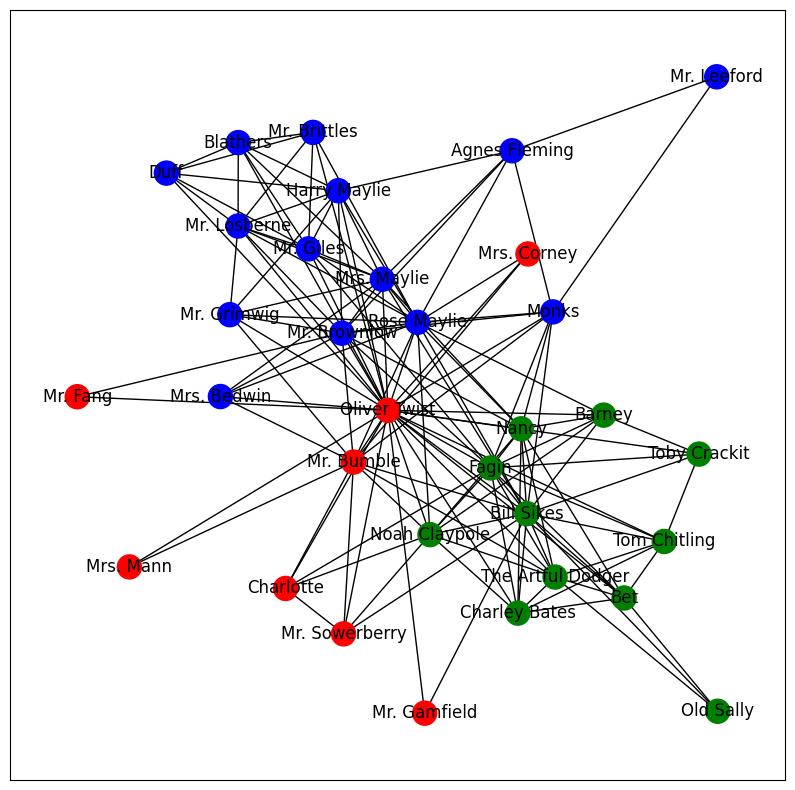

In [ ]:
for n in olivertwist_network.nodes():
    if n in communities[0]:
        olivertwist_network.nodes[n]['color'] = 'b'
    elif n in communities[1]:
        olivertwist_network.nodes[n]['color'] = 'g'
    else:
        olivertwist_network.nodes[n]['color'] = 'r'

pos = networkx.spring_layout(olivertwist_network)
colors = [node[1]['color'] for node in olivertwist_network.nodes(data=True)]

plt.figure(figsize=(10,10))
networkx.draw_networkx(olivertwist_network, pos, with_labels=True, node_color=colors)
plt.show()

Finally, let's see which characters have the highest number of connections in the network using `degree`:

In [ ]:
degrees = dict(networkx.degree(olivertwist_network))
networkx.set_node_attributes(olivertwist_network, name='degree', values=degrees)

And let's look at the scores:

In [ ]:
pd.DataFrame(olivertwist_network.nodes(data='degree'), columns=['node', 'degree']).sort_values(by='degree',ascending=False)

,node,degree
0,Oliver Twist,29
9,Rose Maylie,17
3,Bill Sikes,17
11,Fagin,14
16,Mr. Brownlow,13
2,Mr. Bumble,13
17,Nancy,12
26,Mrs. Maylie,12
8,Noah Claypole,11
5,The Artful Dodger,10


And let's find out who connects the highest number of other nodes in the graph using `betweenness_centrality`:

In [ ]:
betweenness_centrality = networkx.betweenness_centrality(olivertwist_network)
networkx.set_node_attributes(olivertwist_network, name='betweenness_centrality', values=betweenness_centrality)

And let's look at the scores:

In [ ]:
pd.DataFrame(olivertwist_network.nodes(data='betweenness_centrality'), columns=['node', 'betweenness_centrality']).sort_values(by='betweenness_centrality',ascending=False)

,node,betweenness_centrality
0,Oliver Twist,0.398529
3,Bill Sikes,0.089811
9,Rose Maylie,0.073043
29,Monks,0.055661
2,Mr. Bumble,0.045425
11,Fagin,0.038707
16,Mr. Brownlow,0.034943
26,Mrs. Maylie,0.025802
5,The Artful Dodger,0.016478
17,Nancy,0.016464


Let's create a final df with all the information about each node, so that we can export it!

In [ ]:
final_df_graph = pd.DataFrame(dict(olivertwist_network.nodes(data=True))).T
final_df_graph.to_csv('olivertwist_character_network.csv')
final_df_graph

,color,degree,betweenness_centrality
Oliver Twist,r,29,0.398529
Mrs. Mann,r,2,0.0
Mr. Bumble,r,13,0.045425
Bill Sikes,g,17,0.089811
Mr. Gamfield,r,2,0.0
The Artful Dodger,g,10,0.016478
Mr. Sowerberry,r,5,0.000587
Charlotte,r,5,0.000792
Noah Claypole,g,11,0.011638
Rose Maylie,b,17,0.073043
